# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [128]:
import pandas as pd 
import numpy as np
import sklearn
import psycopg2 as psy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

from sklearn import cluster, datasets, preprocessing, metrics
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV

from sqlalchemy import create_engine

%matplotlib inline

In [2]:
%load_ext sql

In [3]:
engine = create_engine('postgresql://localhost')

#### Step 2: Examine your data 

In [4]:
cc_df = pd.read_csv("../assets/airport_cancellations.csv")
op_df = pd.read_csv("../assets/Airport_operations.csv")
ap_df = pd.read_csv("../assets/airports.csv")

### Intro: Write a problem statement / aim for this project

Figure out why there's delays and recommend improvements.

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [5]:
%%sql
postgresql://localhost

'Connected: None@None'

Load our csv files into tables

In [6]:
%%sql
CREATE TABLE airports
(KEY integer, LocID varchar, AP_NAME varchar, ALIAS varchar, Facility_Type varchar, 
 FAA_REGION varchar, COUNTY varchar, CITY varchar, STATE varchar, AP_Type varchar, 
 LATITUDE double precision, LONGITUDE double precision, Boundary_Data_Available varchar);

CREATE TABLE cancellations
(Airport varchar, Year float(1), Departure_Cancellations float(1),
 Arrival_Cancellations float(1), Departure_Diversions float(1),
 Arrival_Diversions float(1));

CREATE TABLE operations
(airport varchar, year integer, departures integer, arrivals integer,
 percent_ontime_gate_departures float(4), percent_ontime_airport_departures float(4),
 percent_ontime_gate_arrivals float(4), average_gate_departure_delay float(2),
 average_taxi_out_time float(2), average_taxi_out_delay float(2),
 average_airport_departure_delay float(2), average_airborne_delay float(2),
 average_taxi_delay float(2), average_block_delay float(2),
 average_gate_arrival_delay float(2));


COPY airports FROM '/Users/Jesse/Documents/GA-DSI/projects/projects-weekly/project-07/assets/airports.csv' WITH CSV HEADER DELIMITER ',';
COPY cancellations FROM '/Users/Jesse/Documents/GA-DSI/projects/projects-weekly/project-07/assets/airport_cancellations.csv' WITH CSV HEADER DELIMITER ',';
COPY operations FROM '/Users/Jesse/Documents/GA-DSI/projects/projects-weekly/project-07/assets/Airport_operations.csv' WITH CSV HEADER DELIMITER ',';

(psycopg2.ProgrammingError) relation "airports" already exists
 [SQL: 'CREATE TABLE airports\n(KEY integer, LocID varchar, AP_NAME varchar, ALIAS varchar, Facility_Type varchar, \n FAA_REGION varchar, COUNTY varchar, CITY varchar, STATE varchar, AP_Type varchar, \n LATITUDE double precision, LONGITUDE double precision, Boundary_Data_Available varchar);']


Join airport_cancellations.csv and airports.csv into one table

In [7]:
# This section of code accomplishes the above requirement but is commented out since I don't use it.

# %%sql
# SELECT
#     *
# FROM cancellations c
# JOIN operations o
# ON (o.airport = c.Airport AND o.year = c.Year)
# LEFT JOIN airports a
# ON a.locid = c.Airport
# WHERE c.airport = 'SJU';

Query the database for our intial data

In [8]:
# df = pd.read_sql('''
# SELECT
#     *
# FROM cancellations c
# JOIN operations o
# ON (o.airport = c.Airport AND o.year = c.Year)
# LEFT JOIN airports a
# ON a.locid = c.Airport
# ORDER BY
#     c.airport,
#     c.year;
# ''', engine)


# df = df.T.drop_duplicates(subset=[1], keep='first').T
# del df['boundary_data_available']
# del df['facility_type']
# del df['county']
# del df['alias']

# Following sections are useless so ignore it unless you don't want to

In [142]:
deets = pd.read_sql('''
SELECT
    *
FROM operations o
LEFT JOIN airports a
ON a.locid = o.Airport
ORDER BY
    o.airport,
    o.year;
''', engine)

In [ ]:
departs = pd.read_sql('''
SELECT
    c.airport,
    c.year,
    o.percent_ontime_gate_departures,
    o.percent_ontime_airport_departures,
    a.faa_region
FROM cancellations c
JOIN operations o
ON (o.airport = c.Airport AND o.year = c.Year)
LEFT JOIN airports a
ON a.locid = c.Airport
GROUP BY
    c.airport,
    c.year,
    o.percent_ontime_gate_departures,
    o.percent_ontime_airport_departures,
    a.faa_region
ORDER BY
    c.airport,
    c.year;
''', engine)

In [11]:
t1_df = departs.groupby('airport').apply(lambda v: linregress(v.year, v.percent_ontime_gate_departures)[0]).to_frame()
t2_df = departs.groupby('airport').apply(lambda v: linregress(v.year, v.percent_ontime_airport_departures)[0]).to_frame()

y1_df = departs.groupby('faa_region').apply(lambda v: linregress(v.year, v.percent_ontime_gate_departures)[0]).to_frame()
y2_df = departs.groupby('faa_region').apply(lambda v: linregress(v.year, v.percent_ontime_airport_departures)[0]).to_frame()

In [67]:
t1_df.sort_values(by=0, inplace=True)
tt1_df = t1_df.head(10)

t2_df.sort_values(by=0, inplace=True)
tt2_df = t2_df.head(10)

y1_df.sort_values(by=0, ascending=False, inplace=True)
yy1_df = y1_df

y2_df.sort_values(by=0, inplace=True)
yy2_df = y2_df

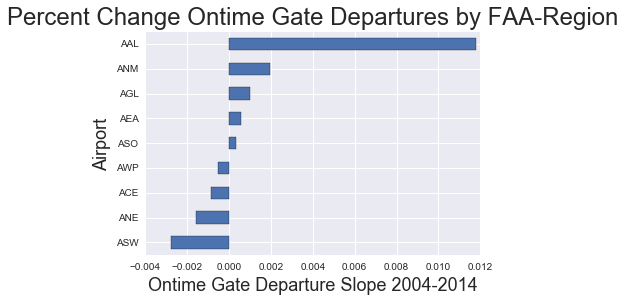

In [70]:
ax = yy1_df[0].plot(kind='barh')
ax.invert_yaxis()
ax.set_xlabel('Ontime Gate Departure Slope 2004-2014', fontsize=18)
ax.set_ylabel('Airport', fontsize=18)
ax.set_title('Percent Change Ontime Gate Departures by FAA-Region', fontsize=24, y=1.01);

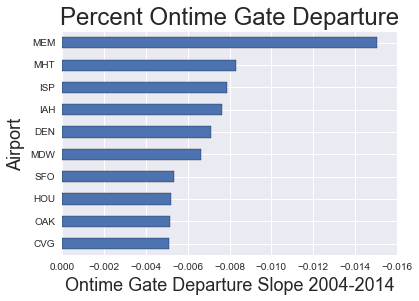

In [14]:
ax = tt1_df[0].plot(kind='barh')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('Ontime Gate Departure Slope 2004-2014', fontsize=18)
ax.set_ylabel('Airport', fontsize=18)
ax.set_title('Percent Ontime Gate Departure', fontsize=24, y=1.01);

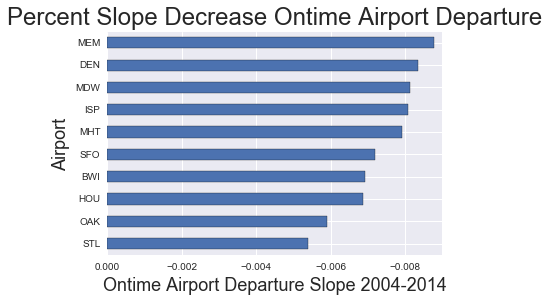

In [126]:
ax = tt2_df[0].plot(kind='barh')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('Ontime Airport Departure Slope 2004-2014', fontsize=18)
ax.set_ylabel('Airport', fontsize=18)
ax.set_title('Percent Slope Decrease Ontime Airport Departure', fontsize=24, y=1.01);

In [16]:
new_columns = op_df.columns.values
new_columns[2] = 'departures'
new_columns[3] = 'arrivals'
new_columns[4] = 'percent_ontime_gate_departures'
new_columns[5] = 'percent_ontime_airport_departures'
new_columns[6] = 'percent_ontime_gate_arrivals'
new_columns[9] = 'average_taxi_out_delay'
op_df.columns = new_columns 

#### 1.2 What are the risks and assumptions of our data? 

#### Assumptions:

#### Risks:
I don't know what I'm doing

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [19]:
op_df.head()

,airport,year,departures,arrivals,percent_ontime_gate_departures,percent_ontime_airport_departures,percent_ontime_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


#### Are there any unique values? 

Uhhhhh yes?

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [20]:
#dummy_ranks = pd.get_dummies(ap_df['FAA REGION'], prefix="region")
#op_df = op_df[op_df.columns.values].join(dummy_ranks.ix[:, :])

#### 3.2 Format and Clean the Data

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

#### 4.2 Find correlations in the data

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: 

#### 4.4 Validate your findings using statistical analysis

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: Perform a PCA

#### 5.1 Conduct the PCA

In [21]:
op_df.ix[:,2:].head()

,departures,arrivals,percent_ontime_gate_departures,percent_ontime_airport_departures,percent_ontime_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [107]:
x = op_df.ix[:,2:14].values
y = op_df.ix[:,0].values

In [108]:
xStand = StandardScaler().fit_transform(x)

In [109]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [110]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort(reverse=True)

In [111]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

In [112]:
airports_pca = PCA(n_components=3)
airports_pca.fit(xStand)
X = airports_pca.transform(xStand)

In [114]:
weight_2d_projection = np.hstack((eigenPairs[0][1].reshape(eigenVectors.shape[1],1),
                                  eigenPairs[1][1].reshape(eigenVectors.shape[1],1)))

In [115]:
poo = op_df.ix[:,2:14]
poo = (poo - poo.mean()) / poo.std()

In [116]:
Z = poo.dot(weight_2d_projection)

In [117]:
tot = sum(eigenValues)
var_exp = [(i / tot)*100 for i in sorted(eigenValues, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[ 47.57620567  81.76648321  88.80868815  92.9094282   96.80559213
  98.19321523  98.92422853  99.53016479  99.96782207  99.99273407
  99.99860957 100.        ]


In [118]:
X = pd.DataFrame(X)

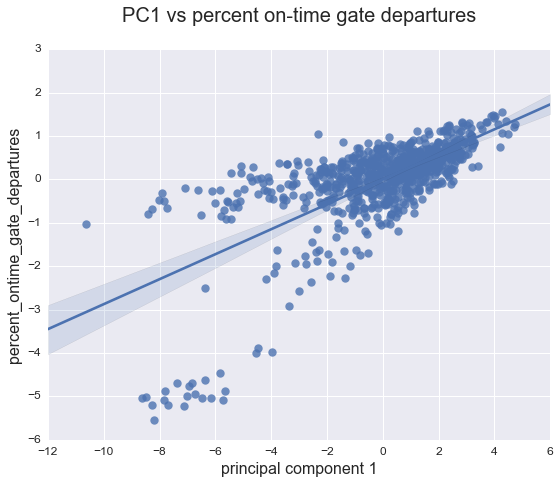

In [127]:
fig = plt.figure(figsize=(9,7))
ax = fig.gca()
ax = sns.regplot(Z.iloc[:,0], poo['percent_ontime_gate_departures'].values,
                 fit_reg=True, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('percent_ontime_gate_departures', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs percent on-time gate departures\n', fontsize=20)

plt.show()

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

In [121]:
k = 3
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [122]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_

In [123]:
metrics.silhouette_score(X, labels, metric='euclidean')

0.49608547595191566

In [140]:
ap_df

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes
5,2884.0,RVR,JOSE APONTE DE LA TORRE,Aeropuerto Jos� Aponte De La Torre,Airport,ASO,#NAME?,CEIBA,PR,Public Use,18.245269,-65.643381,Yes
6,2881.0,MAZ,EUGENIO MARIA DE HOSTOS,Aeropuerto Eugenio Mar�a De Hostos,Airport,ASO,#NAME?,MAYAGUEZ,PR,Public Use,18.255694,-67.148472,Yes
7,5087.0,X95,DIEGO JIMENEZ TORRES,NaN,Airport,ASO,#NAME?,FAJARDO,PR,Public Use,18.308010,-65.661828,No
8,5086.0,CPX,BENJAMIN RIVERA NORIEGA,NaN,Airport,ASO,#NAME?,ISLA DE CULEBRA,PR,Public Use,18.313289,-65.304324,No
9,3442.0,STT,CYRIL E KING,Cyril E King International Airport,Airport,ASO,-VIRGIN ISLANDS-,CHARLOTTE AMALIE,VI,Public Use,18.337306,-64.973361,Yes


In [151]:
dummy_df = X
dummy_df['label'] = labels

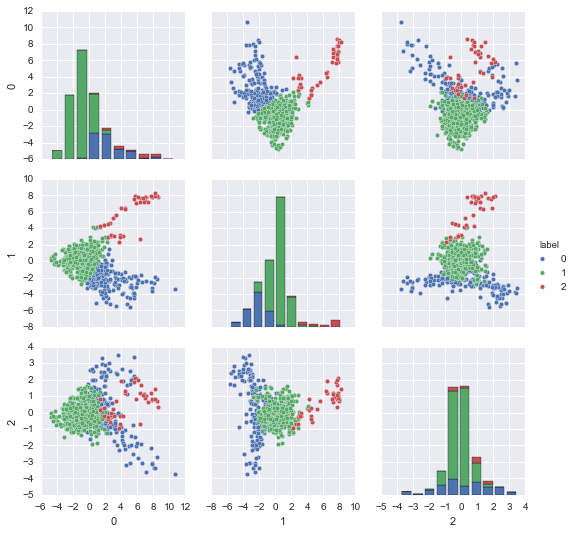

In [152]:
cols = dummy_df.columns[:-1]
sns.pairplot(dummy_df, x_vars=cols, y_vars= cols, hue='label')

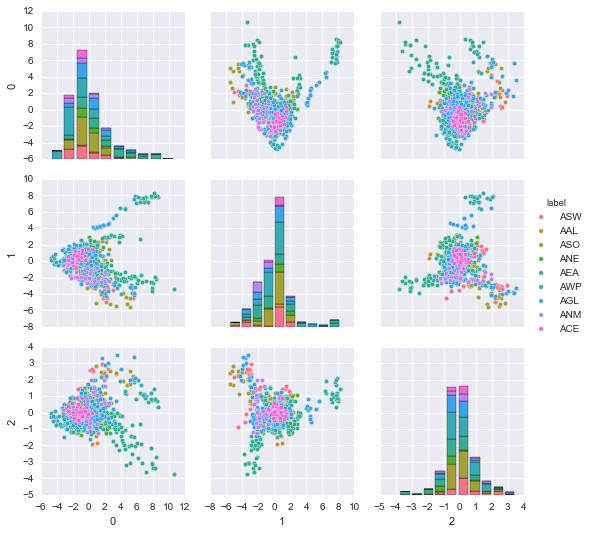

In [153]:
dummy_df = X
dummy_df['label'] = deets['faa_region']

cols = dummy_df.columns[:-1]
sns.pairplot(dummy_df, x_vars=cols, y_vars= cols, hue='label')

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

https://jasanford24.github.io/2016/11/09/project-seven.html

Which operational features are most correlated with delays?

What should the airport's next steps be?

Improve Memphis International Airport. 

### Bonus: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied